In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

%matplotlib notebook

In [53]:
csv_glob = list(Path('../data/').glob('*_weather.csv'))

mapper = {x.name.split('_')[0]: x for x in csv_glob}
print(mapper)

{'EWR': PosixPath('../data/EWR_weather.csv'), 'DEN': PosixPath('../data/DEN_weather.csv'), 'IAD': PosixPath('../data/IAD_weather.csv'), 'ORD': PosixPath('../data/ORD_weather.csv'), 'SYR': PosixPath('../data/SYR_weather.csv')}


In [61]:
anchor_df = pd.read_csv('../data/Detailed_Statistics_Arrivals.csv')

#drop any NaNs.
anchor_df.dropna(inplace=True, axis='rows')

print(anchor_df.shape)

# Remove carrier code, tail number
# Rename Flight Number

anchor_df['Date (MM/DD/YYYY)'] = pd.to_datetime(anchor_df['Date (MM/DD/YYYY)'])
anchor_df.drop(columns=['Carrier Code', 'Tail Number'], axis='columns', inplace=True)
anchor_df['Flight Number'] = anchor_df['Flight Number'].apply(lambda x: "UA " + str(int(x)))
anchor_df['Scheduled Arrival Time'] = pd.to_datetime(anchor_df['Scheduled Arrival Time'])
anchor_df['Arrival Time (Rounded)'] = anchor_df['Scheduled Arrival Time'].dt.round('H')
anchor_df['Scheduled Arrival Time'] = anchor_df['Scheduled Arrival Time'].apply(lambda x: x.time())

# Arrival time.
anchor_df['Arrival Time (Rounded)'] = anchor_df['Arrival Time (Rounded)'].apply(lambda x: x.time())

display(anchor_df.head())

(2090, 15)


,Date (MM/DD/YYYY),Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),Delay National Aviation System (Minutes),Delay Security (Minutes),Delay Late Aircraft Arrival (Minutes),Arrival Time (Rounded)
0,2022-01-01,UA 1282,IAD,23:10:00,00:01,70.0,76.0,51.0,23.0,0.0,6.0,0.0,22.0,23:00:00
1,2023-01-01,UA 604,DEN,14:58:00,14:52,193.0,177.0,-6.0,0.0,0.0,0.0,0.0,0.0,15:00:00
2,2023-01-01,UA 2488,EWR,23:14:00,23:15,75.0,62.0,1.0,0.0,0.0,0.0,0.0,0.0,23:00:00
3,2023-01-01,UA 2645,ORD,23:57:00,23:47,107.0,100.0,-10.0,0.0,0.0,0.0,0.0,0.0,00:00:00
4,2022-01-02,UA 1282,IAD,23:10:00,23:27,70.0,64.0,17.0,17.0,0.0,0.0,0.0,0.0,23:00:00


In [65]:
airport_dfs = []

def preprocess_weather_df(df):
    df['time'] = pd.to_datetime(df['time'])
    df['Date'] = pd.to_datetime(df.time.apply(lambda x: x.date()))
    df['Time'] = df.time.apply(lambda x: x.time())
    df.drop(columns=['time'], inplace=True, axis='columns')
    return df

for airport_name in anchor_df['Origin Airport'].unique():
    
    sub_df = anchor_df.loc[anchor_df['Origin Airport'] == airport_name, :].reset_index(drop=True, inplace=False)
    
    weather_df = preprocess_weather_df(pd.read_csv(mapper[airport_name]))
    
    merged = sub_df.merge(
        right=weather_df,
        left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
        right_on=['Date', 'Time'],
        how='inner'
    ).reset_index(drop=True, inplace=False)
    
    airport_dfs.append(merged)

In [66]:
df = pd.concat(airport_dfs, axis=0)
df = df.sort_values(
    by=['Origin Airport', 'Date (MM/DD/YYYY)'], 
    axis=0, 
    inplace=False
).reset_index(drop=True, inplace=False)

print(df.shape)
display(df.head())

(2090, 40)


,Date (MM/DD/YYYY),Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),...,direct_normal_irradiance,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration,vapor_pressure_deficit,Date,Time
0,2022-02-11,UA 1200,DEN,15:09:00,14:52,199.0,185.0,-17.0,0.0,0.0,...,541.4,16.9,23.8,29,29,39.2,0.12,0.14,2022-02-11,15:00:00
1,2022-02-12,UA 1200,DEN,15:09:00,15:25,199.0,196.0,16.0,16.0,0.0,...,894.4,6.0,8.2,237,229,12.6,0.24,0.38,2022-02-12,15:00:00
2,2022-02-13,UA 1200,DEN,15:09:00,14:59,199.0,188.0,-10.0,0.0,0.0,...,991.7,9.4,13.7,212,203,18.7,0.27,0.42,2022-02-13,15:00:00
3,2022-02-14,UA 1200,DEN,15:09:00,15:14,199.0,195.0,5.0,0.0,0.0,...,1002.3,5.6,6.9,220,223,14.4,0.30,0.46,2022-02-14,15:00:00
4,2022-02-15,UA 1200,DEN,15:09:00,14:55,199.0,188.0,-14.0,0.0,0.0,...,874.5,4.6,4.9,108,107,11.9,0.34,0.91,2022-02-15,15:00:00


In [67]:
# Add SYR weather.
syr_weather = preprocess_weather_df(pd.read_csv(mapper['SYR']))
syr_weather.columns = ['syr_' + x for x in syr_weather.columns]

df = df.merge(
        right=syr_weather,
        left_on=['Date (MM/DD/YYYY)', 'Arrival Time (Rounded)'],
        right_on=['syr_Date', 'syr_Time'],
        how='inner'
    ).reset_index(drop=True, inplace=False)


In [68]:
df.head()

,Date (MM/DD/YYYY),Flight Number,Origin Airport,Scheduled Arrival Time,Actual Arrival Time,Scheduled Elapsed Time (Minutes),Actual Elapsed Time (Minutes),Arrival Delay (Minutes),Delay Carrier (Minutes),Delay Weather (Minutes),...,syr_direct_normal_irradiance,syr_windspeed_10m,syr_windspeed_100m,syr_winddirection_10m,syr_winddirection_100m,syr_windgusts_10m,syr_et0_fao_evapotranspiration,syr_vapor_pressure_deficit,syr_Date,syr_Time
0,2022-02-11,UA 1200,DEN,15:09:00,14:52,199.0,185.0,-17.0,0.0,0.0,...,90.4,23.1,40.1,267,265,49.0,0.14,0.46,2022-02-11,15:00:00
1,2022-02-12,UA 1200,DEN,15:09:00,15:25,199.0,196.0,16.0,16.0,0.0,...,352.9,19.9,31.2,167,169,44.6,0.09,0.20,2022-02-12,15:00:00
2,2022-02-13,UA 1200,DEN,15:09:00,14:59,199.0,188.0,-10.0,0.0,0.0,...,610.3,8.9,12.5,137,139,24.1,0.10,0.14,2022-02-13,15:00:00
3,2022-02-14,UA 1200,DEN,15:09:00,15:14,199.0,195.0,5.0,0.0,0.0,...,646.1,16.5,24.5,148,150,40.0,0.09,0.14,2022-02-14,15:00:00
4,2022-02-15,UA 1200,DEN,15:09:00,14:55,199.0,188.0,-14.0,0.0,0.0,...,324.8,14.4,21.8,167,167,32.0,0.08,0.20,2022-02-15,15:00:00


<IPython.core.display.Javascript object>


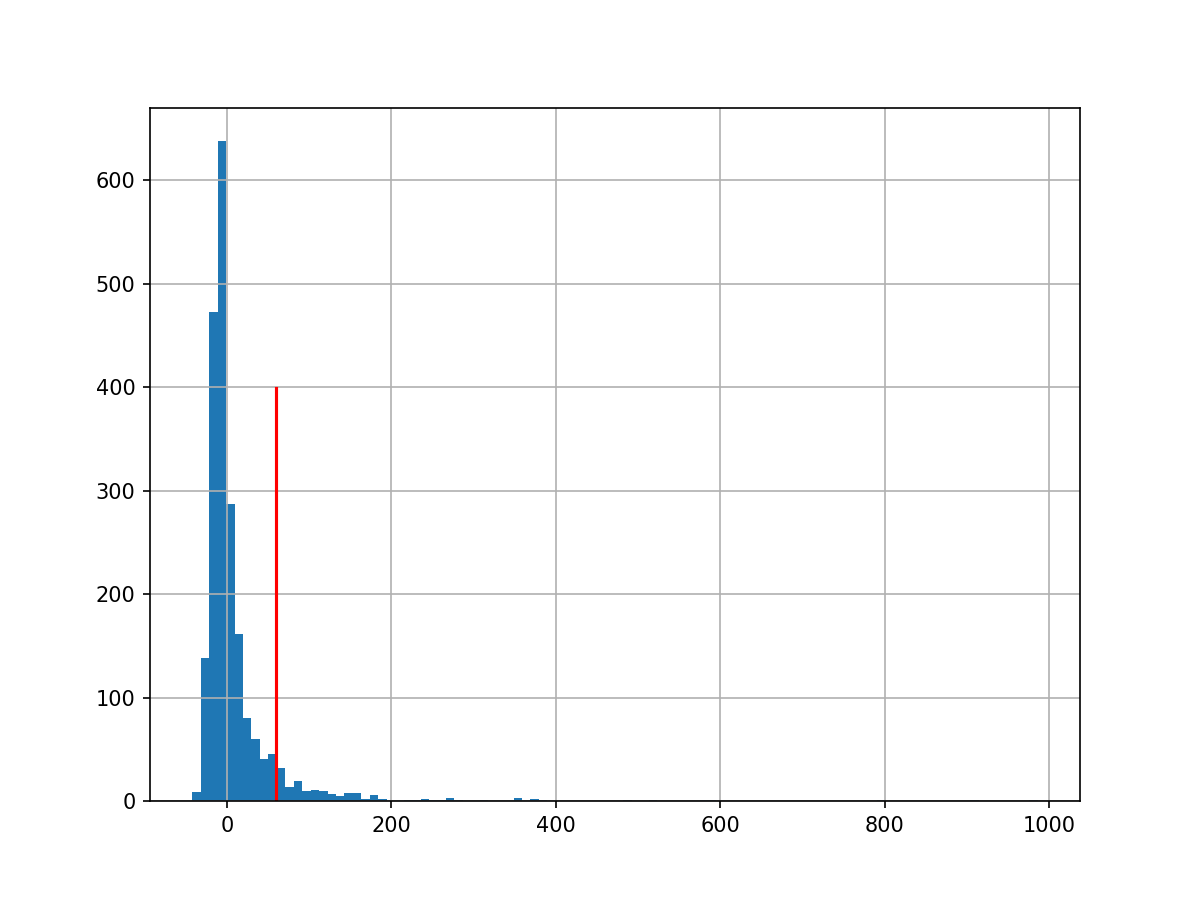

In [69]:
# ON_TIME = 0.
# EARLY = < 0
# DELAYED = > 0 & < 60
# SEVERELY_DELAYED = > 60

fig, ax = plt.subplots(figsize=(8, 6))
df['Arrival Delay (Minutes)'].hist(bins=100, ax=ax)
ax.plot([60 for _ in range(400)], [i for i in range(400)], 'r-')
plt.show()

In [70]:
def create_label(arrival_delay):
    if arrival_delay == 0:
        return "on time"
    if arrival_delay < 0:
        return "early"
    if arrival_delay > 0 and arrival_delay < 60:
        return "delayed"
    if arrival_delay > 60:
        return "severely delayed"
    
    raise NotImplementedError("unknown timeframe")

<IPython.core.display.Javascript object>


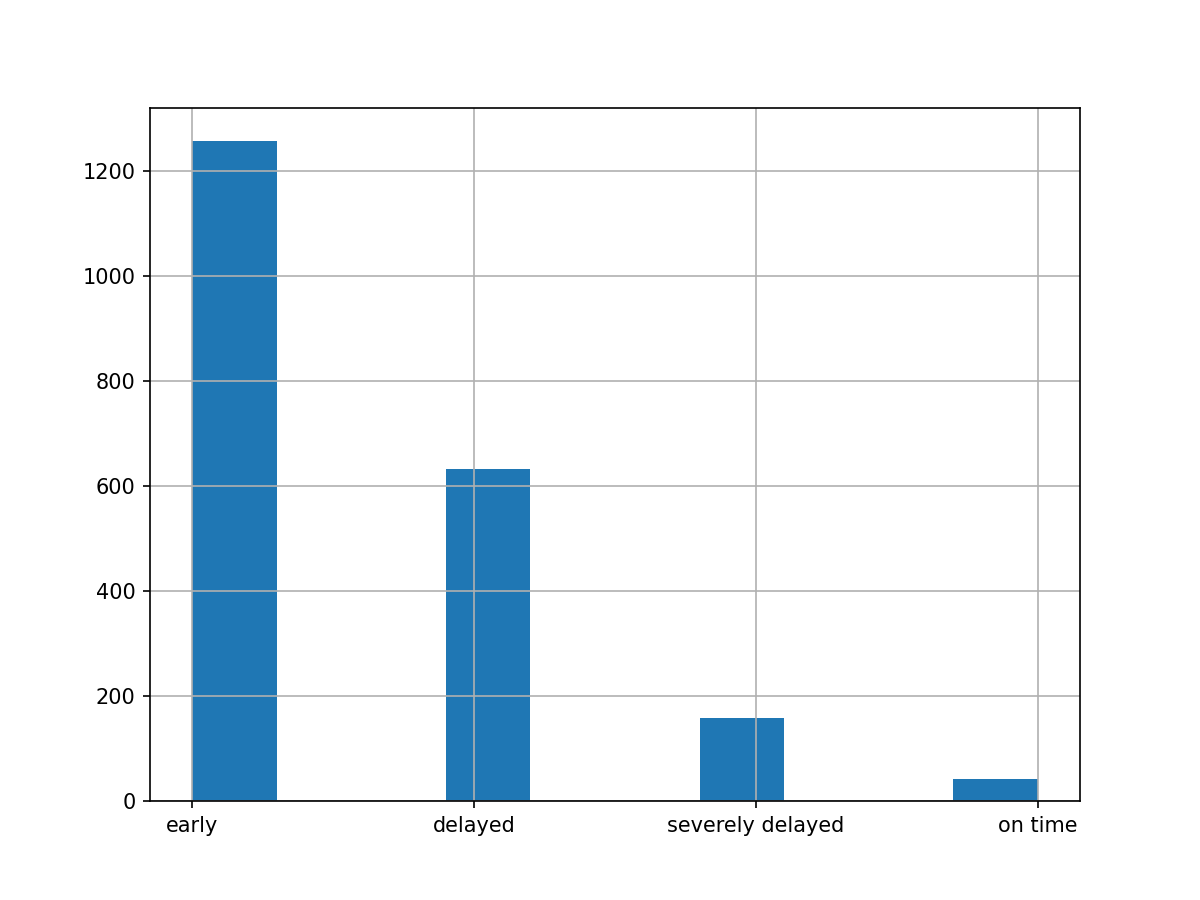

In [71]:
df['arrival_status'] = df['Arrival Delay (Minutes)'].apply(lambda x: create_label(x))

fig, ax = plt.subplots(figsize=(8, 6))
df['arrival_status'].hist(ax=ax)
plt.show()

In [72]:
# Drop unnecessary columns here.

df.drop(
    columns=[
        'Date (MM/DD/YYYY)',
        'Scheduled Arrival Time',
        'Actual Arrival Time',
        'Scheduled Elapsed Time (Minutes)',
        'Actual Elapsed Time (Minutes)',
        'Arrival Delay (Minutes)',                 # TODO: Think about this.
        'Delay Carrier (Minutes)',
        'Delay Weather (Minutes)',
        'Delay National Aviation System (Minutes)',
        'Delay Security (Minutes)', 
        'Delay Late Aircraft Arrival (Minutes)',
        'Arrival Time (Rounded)', 
        'Date', 
        'Time',
        'syr_Date',
        'syr_Time'
    ], axis='columns', inplace=True
)

### Modeling

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [74]:
# OHE
flight_number_encoder = OneHotEncoder()
origin_airport_encoder = OneHotEncoder()

flight_number_ohe = flight_number_encoder.fit_transform(df[['Flight Number']].values).toarray()
airport_ohe = origin_airport_encoder.fit_transform(df[['Origin Airport']].values).toarray()

flight_number_ohe = pd.DataFrame(
    flight_number_ohe, 
    columns=flight_number_encoder.get_feature_names_out()
)

airport_ohe = pd.DataFrame(
    airport_ohe,
    columns=origin_airport_encoder.get_feature_names_out()
)

# Join
df = pd.concat([df, flight_number_ohe, airport_ohe], axis=1)

df.drop(
    columns=['Flight Number', 'Origin Airport'],
    axis='columns',
    inplace=True
)

In [79]:
df.dropna(axis='rows', inplace=True)

In [80]:
X = df.loc[:, ~df.columns.isin(['arrival_status'])]
Y = df.loc[:, 'arrival_status']

X_tr, X_te, Y_tr, Y_te = train_test_split(X, Y, shuffle=True, random_state=420, stratify=Y)

print(f"{X_tr.shape=}, {X_te.shape=}, {Y_tr.shape=}, {Y_te.shape=}")

X_tr.shape=(1566, 143), X_te.shape=(523, 143), Y_tr.shape=(1566,), Y_te.shape=(523,)


In [81]:
scaler = StandardScaler()
X_tr_scaled = pd.DataFrame(scaler.fit_transform(X_tr), columns=scaler.feature_names_in_)
X_te_scaled = pd.DataFrame(scaler.transform(X_te), columns=scaler.feature_names_in_)

In [82]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    n_estimators=300, 
    max_depth=10
).fit(X_tr_scaled, Y_tr)

In [83]:
print(model.score(X_tr_scaled, Y_tr))
print(model.score(X_te_scaled, Y_te))

1.0
0.5717017208413002


In [97]:
feature_df = pd.DataFrame(columns=['feature_name', 'importance'])
feature_df['feature_name'] = model.feature_names_in_
feature_df['importance'] = model.feature_importances_
feature_df.sort_values(by='importance', ascending=False, inplace=True, axis=0)

display(feature_df.head(15))

,feature_name,importance
2,dewpoint_2m,0.048172
4,pressure_msl,0.038927
3,apparent_temperature,0.038055
43,syr_winddirection_10m,0.035739
26,syr_dewpoint_2m,0.033278
44,syr_winddirection_100m,0.032866
5,surface_pressure,0.031123
42,syr_windspeed_100m,0.030273
29,syr_surface_pressure,0.029774
25,syr_relativehumidity_2m,0.027524


In [89]:
pred_df = pd.DataFrame(
    {
        'y_true': Y_te,
        'y_pred': model.predict(X_te)
    }
)

display(pred_df)

,y_true,y_pred
321,severely delayed,delayed
408,early,severely delayed
1184,severely delayed,delayed
1232,early,delayed
1208,severely delayed,delayed
...,...,...
1515,early,severely delayed
1499,early,delayed
8,delayed,delayed
2073,severely delayed,severely delayed


<IPython.core.display.Javascript object>


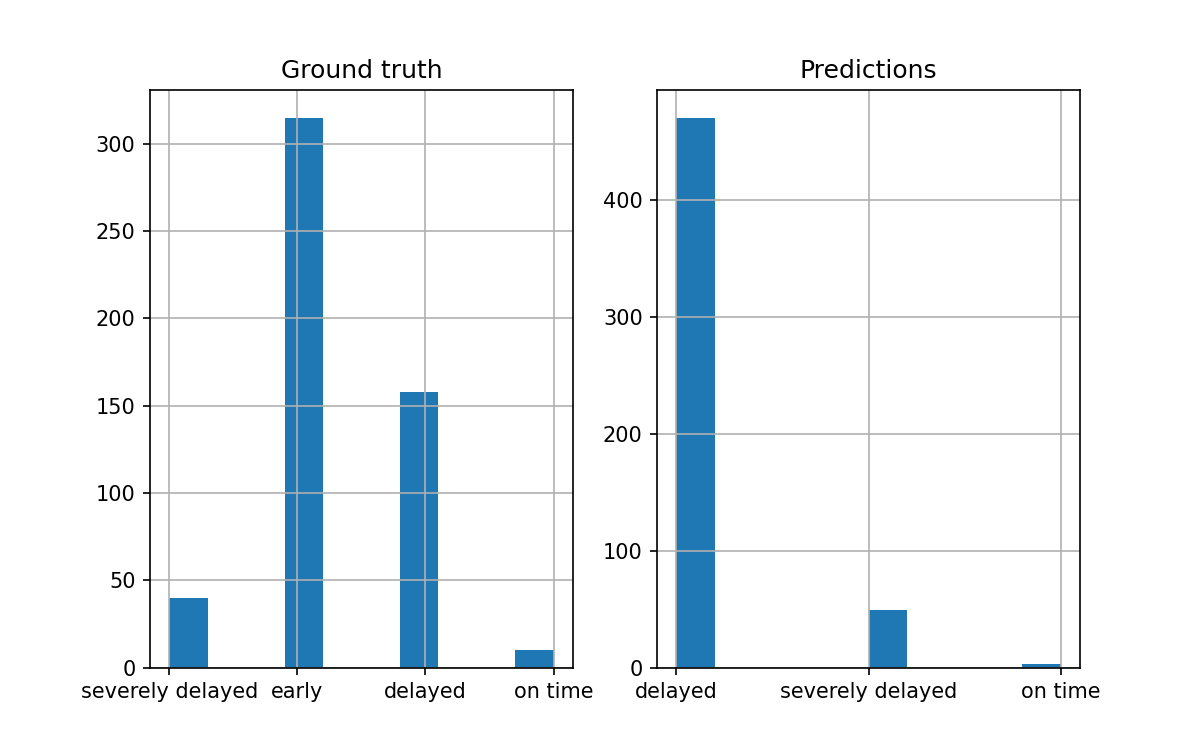

In [95]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
pred_df.y_true.hist(ax=ax[0])
pred_df.y_pred.hist(ax=ax[1])
ax[0].set_title('Ground truth')
ax[1].set_title('Predictions')
plt.show()